# Super resoluiton Part 1: make the dataset

---
Author:
- [@yueyingn](https://github.com/yueyingn) (Yueying Ni)

## Overview

Super resolution can be applied to many different tasks. In this notebook, we will introduce 2 simple examples and show how to properly format the images and create the dataset for ML trainings.

1) Dark matter density field (the cosmic web) produced by simulations

2) The galaxy images from observations

**Welcome to come up with your own dataset!**

---

In [1]:
%pylab inline
from glob import glob
import h5py
import torch
from torch import Tensor
import torch.nn.functional 
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torchvision.transforms import Resize as VisionResize

---
## Dataset 1: Galaxy images

Galaxy10 DECals is a dataset contains 17736 256x256 pixels colored galaxy images (g, r and z band) separated in 10 classes. For details, see https://astronn.readthedocs.io/en/latest/galaxy10.html

We choose a subset of the galaxies that have spirial morphologies

In [3]:
with h5py.File('/ocean/projects/phy230064p/shared/superresolution/Galaxy10_DECals.h5', 'r') as data:
    gal_images = np.array(data['images'])
    labels = np.array(data['ans'])
    
mask = (labels>=5)&(labels<=7) # select spiral galaxies
gal_images = gal_images[mask]
print ("shape of the data:",gal_images.shape)

gal_images = gal_images.astype(np.float32)
gal_images /= 255.0 # normalize the data

shape of the data: (6500, 256, 256, 3)


The image has 3 chanels (RGB) that represent galaxy color in g,r,z band of DESI survey.
Here is a quick illustration of the galaxy images

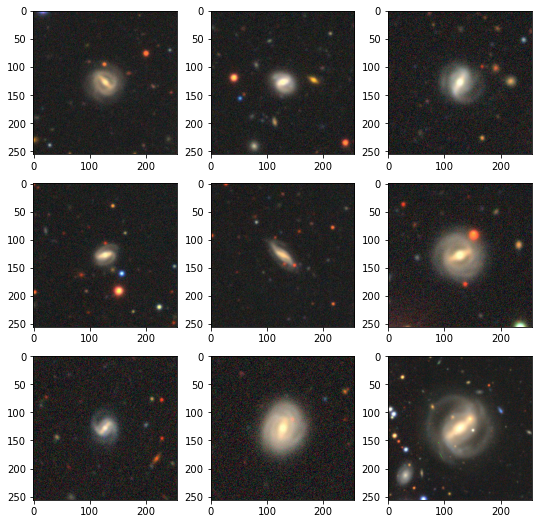

In [4]:
f, axes = plt.subplots(3,3,figsize=(9,9))
for i in range(0,9):
    axes.flat[i].imshow(gal_images[i])

The raw data has shape (N, H, W, C) that is also took by plt.show
However, for ML trainings, we need the convert data to torch.Tensor in shape of (N, C, H, W), where the channel dimension is before the spatial dimension:

In [5]:
gal_images = np.moveaxis(gal_images,-1,1) # transform (N,H,W,C)->(N,C,H,W)
gal_images = torch.Tensor(gal_images) # convert to Tensor
print ("shape of the data:",gal_images.shape)

shape of the data: torch.Size([6500, 3, 256, 256])


---
## Dataset 2: Cosmic Web 

As an simple example, here we use 2D maps of the dark matter density field from the CAMELS multi field dataset. For details, see https://camels-multifield-dataset.readthedocs.io/en/latest/)

Here data contains 405 256x256 pixels. The images only have 1 channel (that represents the density).

In [6]:
basePath = '/ocean/projects/phy230064p/shared/superresolution/'
simPath = basePath + '/Maps_Mcdm_IllustrisTNG_CV_z=0.00.npy'
dm_map = np.load(simPath)

# density  normalize the data
dm_map = np.log10(dm_map)
dm_map = (dm_map - dm_map.mean()) / dm_map.std()
print ("shape of the data:",dm_map.shape)

shape of the data: (405, 256, 256)


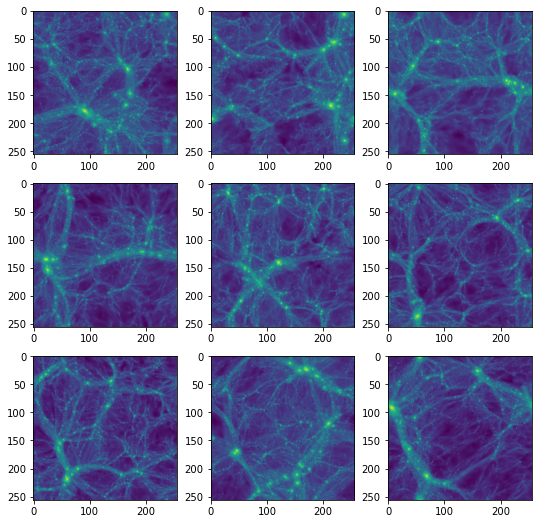

In [7]:
f, axes = plt.subplots(3,3,figsize=(9,9))
for i in range(0,9):
    axes.flat[i].imshow(dm_map[i])

Here the data is in shape of (N,H,W), we need to add a channel dimension and convert it to the shape of (N,C,H,W)

In [8]:
dm_map = torch.Tensor(dm_map)
dm_map = dm_map.unsqueeze(1) # (N,H,W) -> (N,C,H,W)
print ("shape of the data:",dm_map.shape)

shape of the data: torch.Size([405, 1, 256, 256])


---
## Data Augmentation

If the data is translational or rotational invariant (or both), the SR operation should also perserve the same symmertry. We can apply the coresponding translation and rotation operations when loading the data. 

In [9]:
class Translate(object):
    """
    Apply translation to the input image
    """
    def __init__(self, ndim):
        self.ndim = ndim
        
    def __call__(self, sample):
        in_img = sample 
        
        shift_dims = tuple(np.arange(self.ndim)-self.ndim)
        shift_pixels = tuple([torch.randint(in_img.shape[d], (1,)).item() for d in shift_dims])

        in_img = torch.roll(in_img, shift_pixels, dims=shift_dims)
        
        return in_img
    

class Flip(object):
    """
    Flip the input images 
    """
    def __init__(self, ndim):
        self.axes = None
        self.ndim = ndim

    def __call__(self, sample):
        assert self.ndim > 1, "flipping is ambiguous for 1D scalars/vectors"

        self.axes = torch.randint(2, (self.ndim,), dtype=torch.bool)
        self.axes = torch.arange(self.ndim)[self.axes]

        in_img = sample

        if in_img.shape[0] == self.ndim:  # flip vector components
            in_img[self.axes] = -in_img[self.axes]

        shifted_axes = (1 + self.axes).tolist()
        in_img = torch.flip(in_img, shifted_axes)

        return in_img
    

class Permutate(object):
    """
    Permutate the input images 
    """
    def __init__(self, ndim):
        self.axes = None
        self.ndim = ndim

    def __call__(self, sample):
        assert self.ndim > 1, "permutation is not necessary for 1D fields"

        self.axes = torch.randperm(self.ndim)
        
        in_img = sample

        if in_img.shape[0] == self.ndim:  # permutate vector components
            in_img = in_img[self.axes]

        shifted_axes = [0] + (1 + self.axes).tolist()
        in_img = in_img.permute(shifted_axes)

        return in_img

---
## Prepare Dataset for super resolution

Here we use VisionResize to post-process data to high-res and low-res images as for test and illustration purpose. (In a realistic user case, we would want to use real low-res data from e.g. low resolution simulation or observations)

In [14]:
class SupResDataset(Dataset):
    """
    Make the pairs of LR, HR img pairs
    """
    def __init__(self, imgs, lr_size, hr_size, transform=None):
        """
        imgs: original img in shape of (N,C,H,W)
        lr_size: size of low resolution
        hr_size: size of high resolution
        transform: operations of data augmentation, before resizing to HR and LR
        """
        self.imgs = imgs
        self.transform = transform
        self.lr_resize = VisionResize(lr_size, antialias=False)
        self.hr_resize = VisionResize(hr_size, antialias=False)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        
        if self.transform is not None:
            img = self.transform(img)
        
        LR_img = self.lr_resize(img)
        HR_img = self.hr_resize(img)
            
        return LR_img, HR_img

---
## Make the DataLoader

### (1) galaxy dataset
For galaxy images, we prefer to have the galaxy at the center, so we only apply Flip and Permutation as data augmentation.

In [21]:
ndim = 2
train_transforms = transforms.Compose([Flip(ndim),Permutate(ndim)]) # rotation of the image

# create the dataset
dataset = SupResDataset(gal_images, lr_size=32, hr_size=128, transform=train_transforms)

# split dataset for training and validation
train_set_size = int(len(dataset) * 0.9)
val_set_size = len(dataset) - train_set_size
train_dataset, val_dataset = random_split(dataset, [train_set_size, val_set_size])

# Create train and validation data loaders
BATCH_SIZE = 4
train_iterator = DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE)
val_iterator = DataLoader(val_dataset,batch_size=BATCH_SIZE)

visualize the images

torch.Size([4, 3, 32, 32]) torch.Size([4, 3, 128, 128])
torch.Size([4, 3, 32, 32]) torch.Size([4, 3, 128, 128])
torch.Size([4, 3, 32, 32]) torch.Size([4, 3, 128, 128])


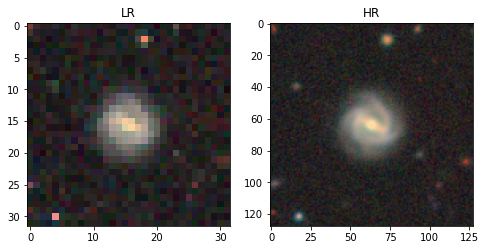

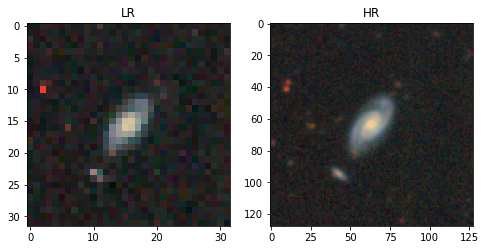

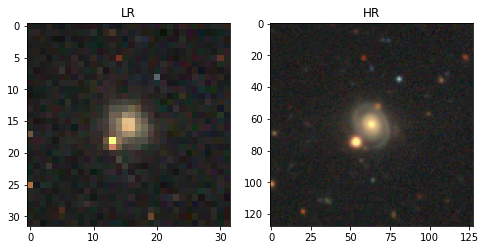

In [22]:
iter_train = iter(train_iterator)
for n in range(3):
    lr_img, hr_img = next(iter_train)
    print (lr_img.shape,hr_img.shape)
    fig, ax = plt.subplots(ncols=2,figsize=(8,8))
    ax[0].imshow(torch.moveaxis(lr_img[0],0,-1))
    ax[0].set_title('LR')
    ax[1].imshow(torch.moveaxis(hr_img[0],0,-1))
    ax[1].set_title('HR')

### (2) DM density map dataset
For cosmic web (with periodic boundary condition), we can apply both translation and rotation operations

In [23]:
ndim = 2
# translation + rotation of the image
train_transforms = transforms.Compose([Translate(ndim),Flip(ndim),Permutate(ndim)]) 

# create the dataset
dataset = SupResDataset(dm_map, lr_size=32, hr_size=128, transform=train_transforms)

# split dataset for training and validation
train_set_size = int(len(dataset) * 0.9)
val_set_size = len(dataset) - train_set_size
train_dataset, val_dataset = random_split(dataset, [train_set_size, val_set_size])

# Create train and validation data loaders
BATCH_SIZE = 4
train_iterator = DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE)
val_iterator = DataLoader(val_dataset,batch_size=BATCH_SIZE)

visualize the image

torch.Size([4, 1, 32, 32]) torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 32, 32]) torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 32, 32]) torch.Size([4, 1, 128, 128])


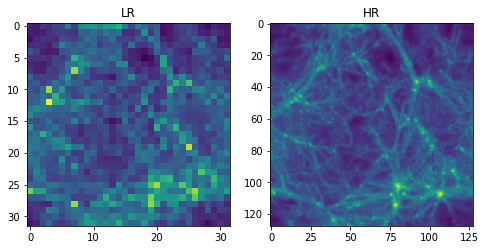

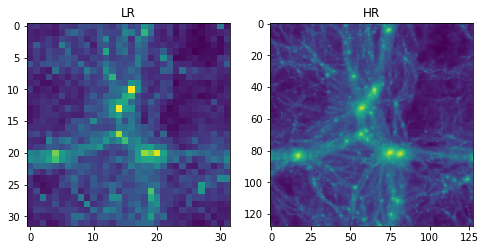

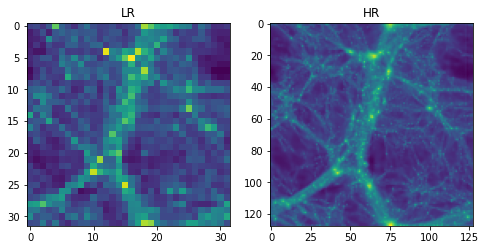

In [25]:
iter_train = iter(train_iterator)
for n in range(3):
    lr_img, hr_img = next(iter_train)
    print (lr_img.shape,hr_img.shape)
    fig, ax = plt.subplots(ncols=2,figsize=(8,8))
    ax[0].imshow(lr_img[0].squeeze())
    ax[0].set_title('LR')
    ax[1].imshow(hr_img[0].squeeze())
    ax[1].set_title('HR')

---

Also, let's take a look at what does the interpolated LR img look like --- not so good

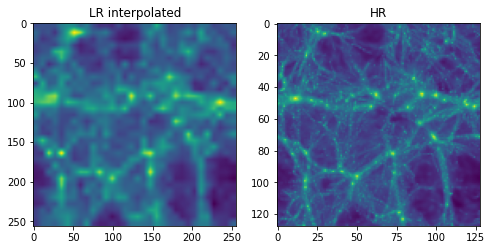

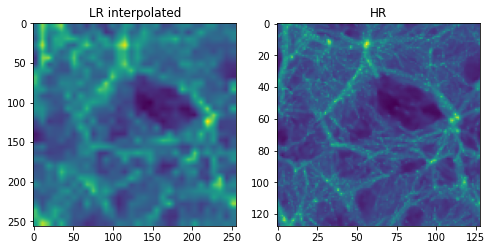

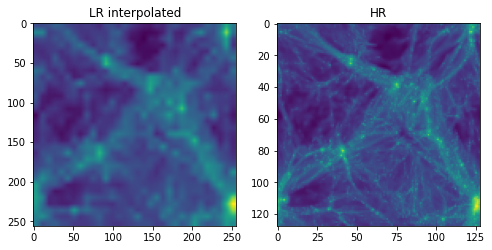

In [26]:
iter_train = iter(train_iterator)
for n in range(3):
    lr_img, hr_img = next(iter_train)
    fig, ax = plt.subplots(ncols=2,figsize=(8,8))
    # up interpolate the LR image
    lr_img = torch.nn.functional.interpolate(lr_img,scale_factor=8,mode='bilinear', align_corners=False)
    ax[0].imshow(lr_img[0].squeeze())
    ax[0].set_title('LR interpolated')
    ax[1].imshow(hr_img[0].squeeze())
    ax[1].set_title('HR')

--- Now we are ready to develop DL models to super resolve the low resolution images!